# 1. 직접 손으로 수식을 써가며 아래 데이터셋의 Decision Tree Classifier 만들어보기

In [21]:
data = pd.read_excel("tennis.xlsx")

data.head()

,Outlook,Temperature,Humidity,Windy,Play
0,sunny,hot,high,False,No
1,sunny,hot,high,True,No
2,overcast,hot,high,False,Yes
3,rain,mild,high,False,Yes
4,rain,cool,normal,False,Yes


# 2. 코드를 써서 diabetes.csv 데이터의 Decision Tree Classifier 만들어보기

## 데이터셋 로드 및 Pruning 없이 tree 제작

In [1]:
# 모듈 import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz 
import pydot
from IPython.core.display import Image 
from sklearn.metrics import accuracy_score

In [2]:
# 데이터셋 불러오기
data = pd.read_csv("diabetes.csv")

data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
X = data.drop("Outcome", axis=1)
y = data["Outcome"]

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [5]:
# Pruning 이전 
clf = DecisionTreeClassifier(random_state=0)
tree_nottuned = clf.fit(X_train, y_train)

In [6]:
# 트리 시각화 함수
def draw_decision_tree(clf, feature_names = None, class_names = None):
    dot_data = export_graphviz(clf, out_file = None, 
                                feature_names = feature_names,
                                class_names = class_names,
                                filled = True, 
                                rounded = True,
                                special_characters = True)
    graph = pydot.graph_from_dot_data(dot_data)[0]
    image = graph.create_png()
    return Image(image)

In [7]:
feature_names = list(X.columns)
class_names = "Outcome"

draw_decision_tree(tree_nottuned, feature_names=feature_names, class_names=class_names)

Output hidden; open in https://colab.research.google.com to view.

## Pruning - 사전 가지치기

In [8]:
from sklearn.model_selection import cross_validate

scoring = ['f1','precision','recall']
tree_scores = cross_validate(tree_nottuned, X_train, y_train, scoring=scoring, cv=5, return_train_score = False)

print("parameter가 tuning 되지 않았을 때의 F1 Score : {:.3f}".format(np.mean(tree_scores['test_f1'])))

parameter가 tuning 되지 않았을 때의 F1 Score : 0.545


In [9]:
y_pred = clf.predict(X_train)
print("parameter가 tuning 되지 않았을 때의 accuracy:", accuracy_score(y_train, y_pred))

parameter가 tuning 되지 않았을 때의 accuracy: 1.0


In [10]:
from sklearn.model_selection import GridSearchCV

hyperparamters = {'max_depth': list(range(2, 8)),  'min_samples_split': list(range(2, 20))}

GridCV = GridSearchCV(estimator=tree_nottuned, param_grid=hyperparamters, cv=5, verbose=1)
GridCV.fit(X_train, y_train)

GridCV.best_params_

Fitting 5 folds for each of 108 candidates, totalling 540 fits


{'max_depth': 4, 'min_samples_split': 2}

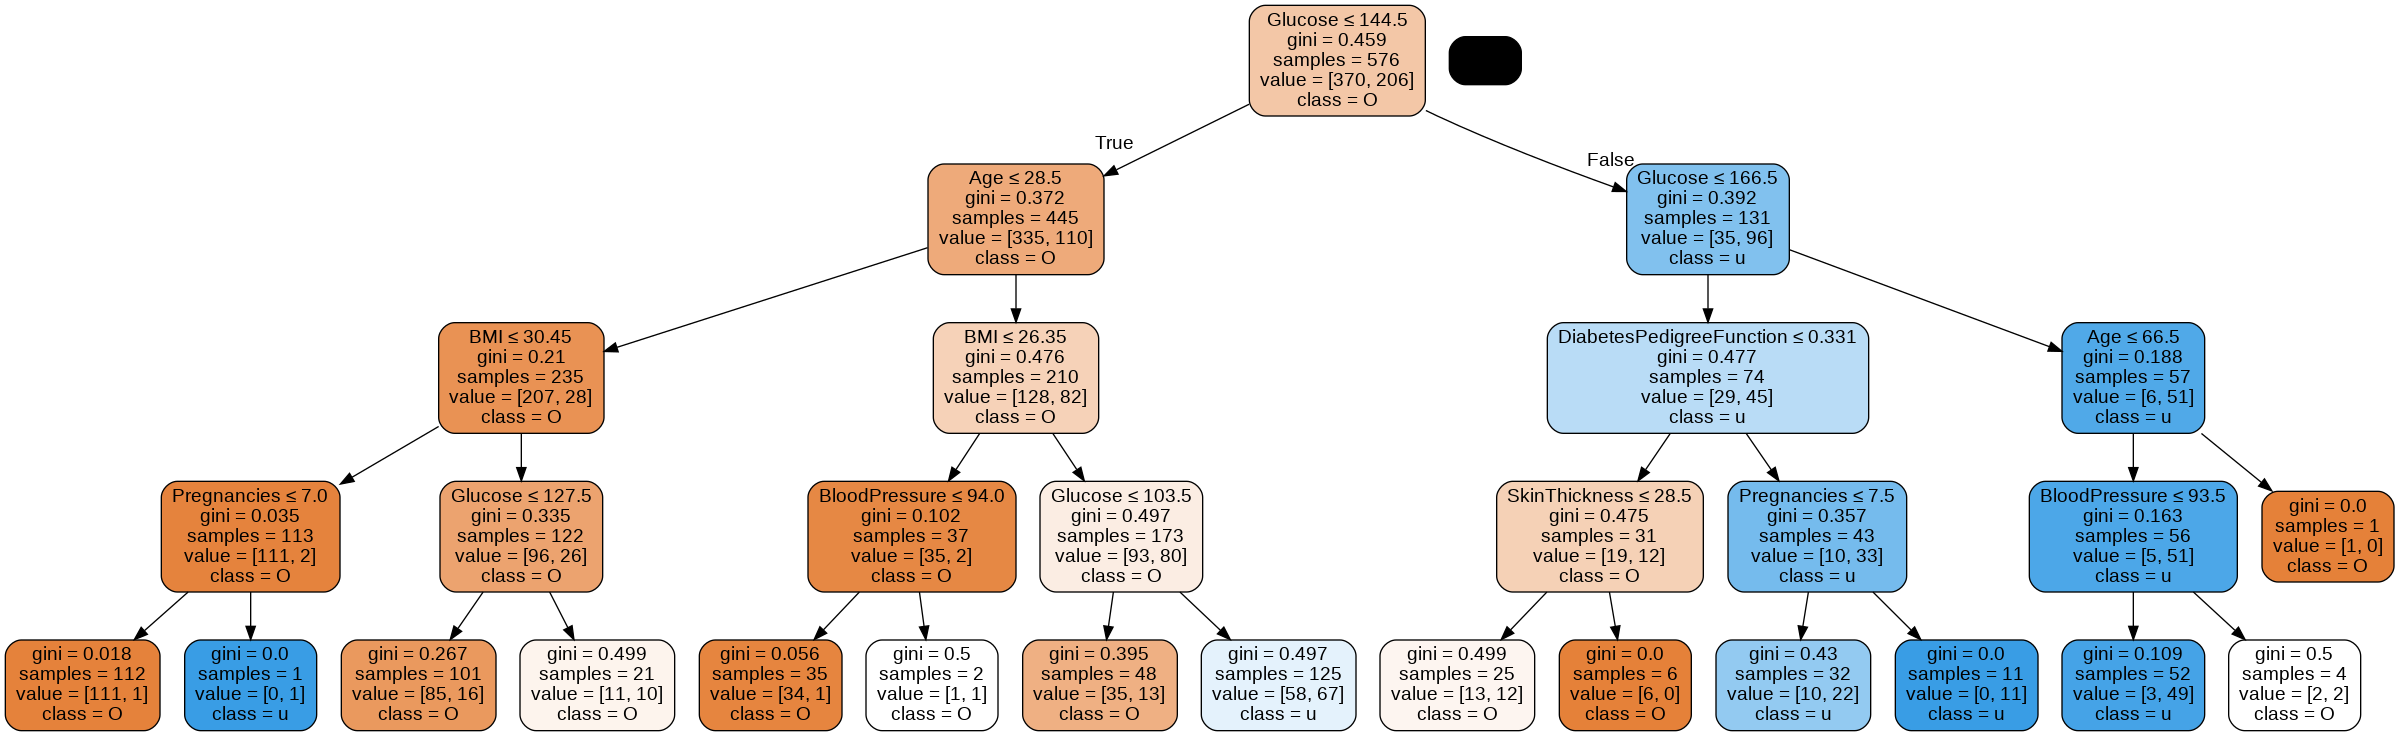

In [11]:
clf = DecisionTreeClassifier(max_depth=4, min_samples_split=2, random_state=0)
tree_tuned = clf.fit(X_train, y_train)

draw_decision_tree(tree_tuned, feature_names=feature_names, class_names=class_names)

In [12]:
tree_tuned_scores = cross_validate(tree_tuned, X_train, y_train, scoring=scoring, cv=5, return_train_score = False)

print("parameter가 tuning 된 후의 F1 Score : {:.3f}".format(np.mean(tree_tuned_scores['test_f1'])))

parameter가 tuning 된 후의 F1 Score : 0.608


In [13]:
y_pred = clf.predict(X_train)
print("parameter가 tuning 된 후의 accuracy:", accuracy_score(y_train, y_pred))

parameter가 tuning 된 후의 accuracy: 0.7795138888888888


## Pruning - 사후 가지치기

In [14]:
clf = DecisionTreeClassifier(random_state=0)

path = clf.cost_complexity_pruning_path(X_train, y_train)

# effective alphas, corresponding total leaf impurities 구하기
ccp_alphas, impurities = path.ccp_alphas, path.impurities

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

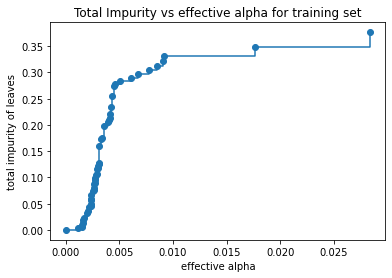

In [15]:
# effective alpha값에 따른 total impurity of leaves 그래프

fig, ax = plt.subplots()
# plt.subplots() 편의 함수는 Figure 객체를 생성하고 Figure.subplots()를 호출하여 리턴
# axes: 좌표평면을 나타내는 변수

# ccp_alphas[-1]은 노드가 하나밖에 없는 트리임.
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

# alpha 값이 커지면 트리가 작아짐 -> total impurity of leaves 커짐

- 각 effective alphas 이용해 decision tree 만들기

In [16]:
# effective alpha 값에 대응하는 sub-trees 시각화

clfs = []
count = 0
for ccp_alpha in ccp_alphas:
    # 각 effective alphas 이용해 decision tree 만들기
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf = clf.fit(X_train, y_train)
    count += 1
    print("Number of nodes in the {}th tree is: {} with ccp_alpha: {}".format(
      count, clf.tree_.node_count, ccp_alpha))
    display(draw_decision_tree(clf, feature_names, class_names))
    clfs.append(clf)
    print("====================================================================================")

# ccp_alpha = 0 일 때는 not-pruned full tree
# ccp_alpha를 0부터 시작해서 크기를 늘려감, effective alpha를 지나면 가지치기
# 마지막에는 root node만 남음
# alpha에 따라서 subtree의 크기를 조정할 수 있음을 확인

Output hidden; open in https://colab.research.google.com to view.

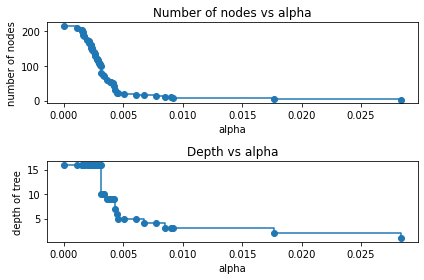

In [17]:
# alpha값에 따른 node 수의 트리의 깊이

# 노드가 하나뿐인 마지막 tree는 제외
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

# tree의 node 수
node_counts = [clf.tree_.node_count for clf in clfs]

# tree의 depth
depth = [clf.tree_.max_depth for clf in clfs]

fig, ax = plt.subplots(2, 1)
# Number of nodes vs alpha
ax[0].plot(ccp_alphas, node_counts, marker='o', drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
# Depth vs alpha
ax[1].plot(ccp_alphas, depth, marker='o', drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

# alpha 값이 커지면 트리는 작아지므로, node의 수와 트리의 깊이도 작아짐

- Accuracy vs alpha for training and testing sets
  - alpha 값에 대응하는 subtree의 성능 확인

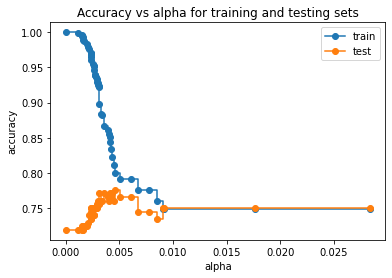

Decision tree without pruning : 215 nodes, 0.719 accuracy
Decision tree with the best pruning : 21 nodes, 0.776 accuracy


In [18]:
# testing accuracy를 높이는 최고의 ccp_alpha는?

train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show()

print("Decision tree without pruning : {0} nodes, {1:.3} accuracy".format(tree_nottuned.tree_.node_count, tree_nottuned.score(X_test, y_test)))
print("Decision tree with the best pruning : {0} nodes, {1:.3} accuracy".format(clfs[test_scores.index(max(test_scores))].tree_.node_count, max(test_scores)))

# 가장 높은 accuracy를 보이는 ccp_alpha 값은 약 0.0045
# effective alpha = 약 0.0045일 때 가장 높은 성능을 가지는 sub-tree가 만들어짐

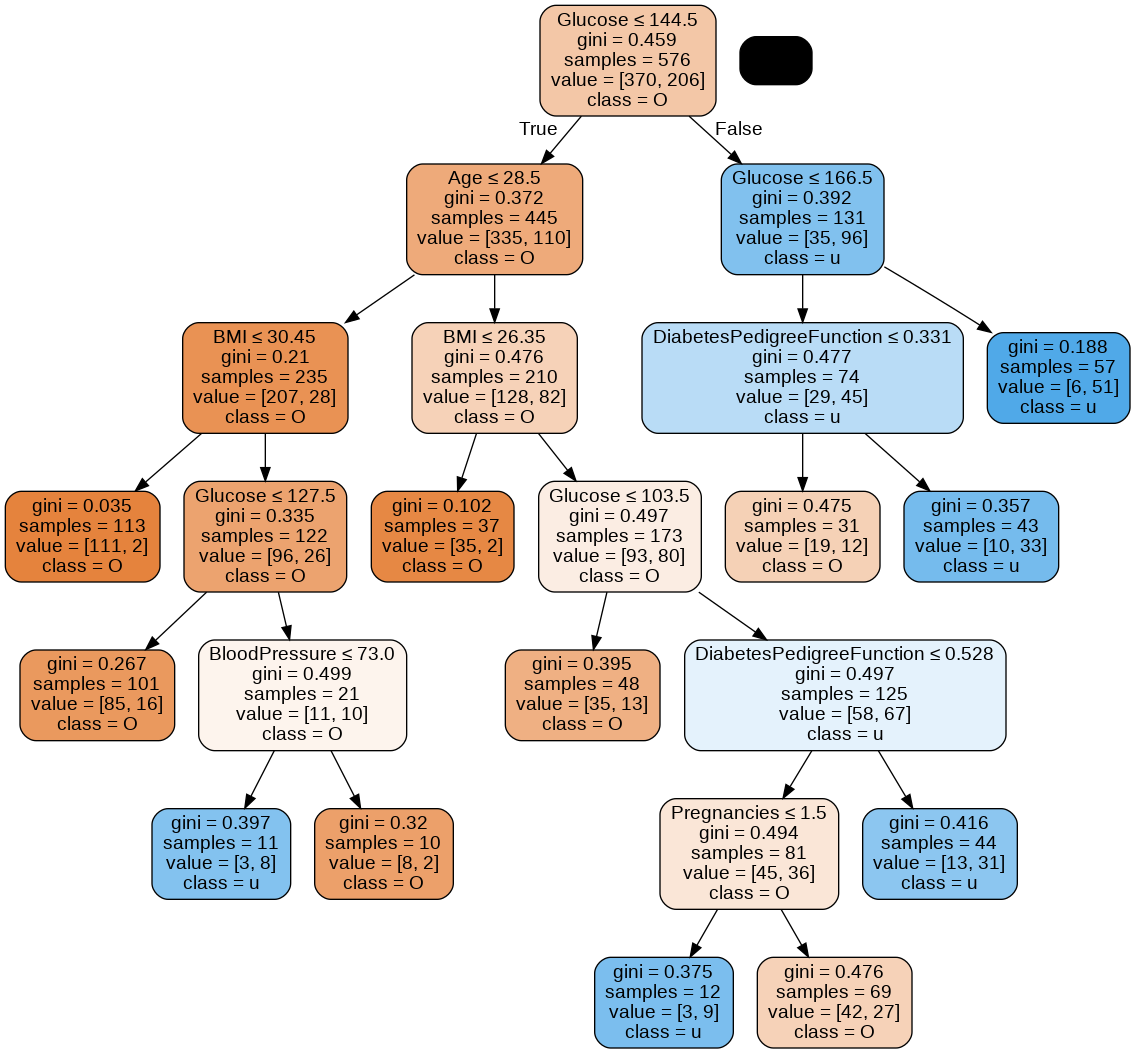

In [19]:
# testing accuracy를 높이는 최고의 ccp_alpha
clf = DecisionTreeClassifier(random_state=0, ccp_alpha=0.0045)
clf = clf.fit(X_train, y_train)
draw_decision_tree(clf, feature_names, class_names)

# sub-trees 중 가장 성능 좋음
# overfitting 방지되었다고 추정

In [20]:
y_pred = clf.predict(X_train)
print("parameter가 tuning 된 후의 accuracy:", accuracy_score(y_train, y_pred))

parameter가 tuning 된 후의 accuracy: 0.8107638888888888


- 사전 가지치기를 진행한 tree의 accuracy: 0.7795138888888888
- 사후 가지치기를 진행한 tree의 accuracy: 0.8107638888888888